# Building Models with Custom Activation Functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For importing the MNIST data set:
from sklearn.datasets import fetch_openml

# For visualizing loop progress:
from tqdm import tqdm

# PyTorch imports:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset

### Activate the GPU for faster model training

To activate the GPU: \> Runtime \> Change runtime type \> Pick whatever GPU is available.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
print("^^^^ if cuda is printed, we are using the GPU!")

cuda
^^^^ if cuda is printed, we are using the GPU!


### Load and visualize the MNIST data set

MNIST data loaded succesfully!
Image data: X.shape = (70000, 784)
Label data: y.shape = (70000,)



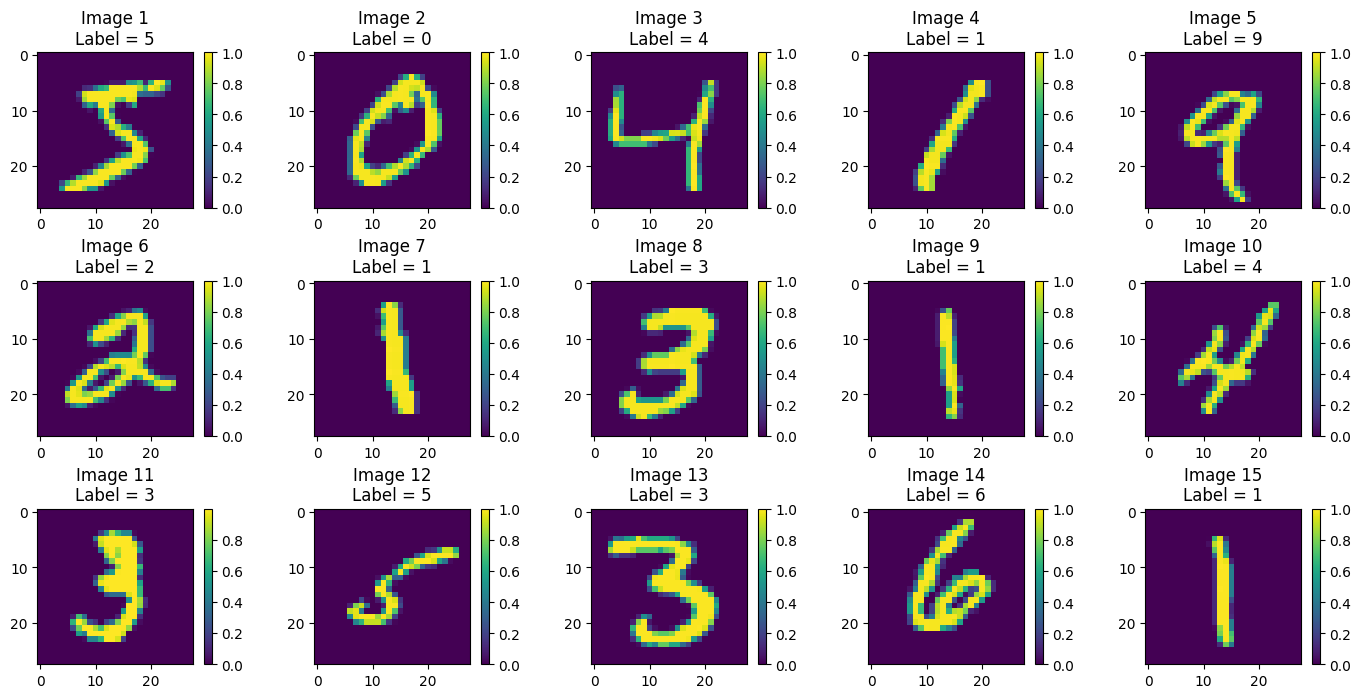

In [ ]:
# Load the MNIST data:
mnist = fetch_openml("mnist_784", parser="auto")
X = np.array(mnist.data) / 255.0  # Scale the data to [0, 1]
y = np.array(mnist.target).astype(int)

# Print some data information:
print("MNIST data loaded succesfully!")
print(f"Image data: X.shape = {X.shape}")
print(f"Label data: y.shape = {y.shape}")
print()

# Plot some of the MNIST images.
plt.figure(figsize=(14, 7))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.title(f"Image {i + 1}\nLabel = {y[i]}")
    plt.imshow(X[i, :].reshape(28, 28))
    plt.colorbar()
plt.tight_layout()
plt.show()

### Pollute the data with Gaussian noise

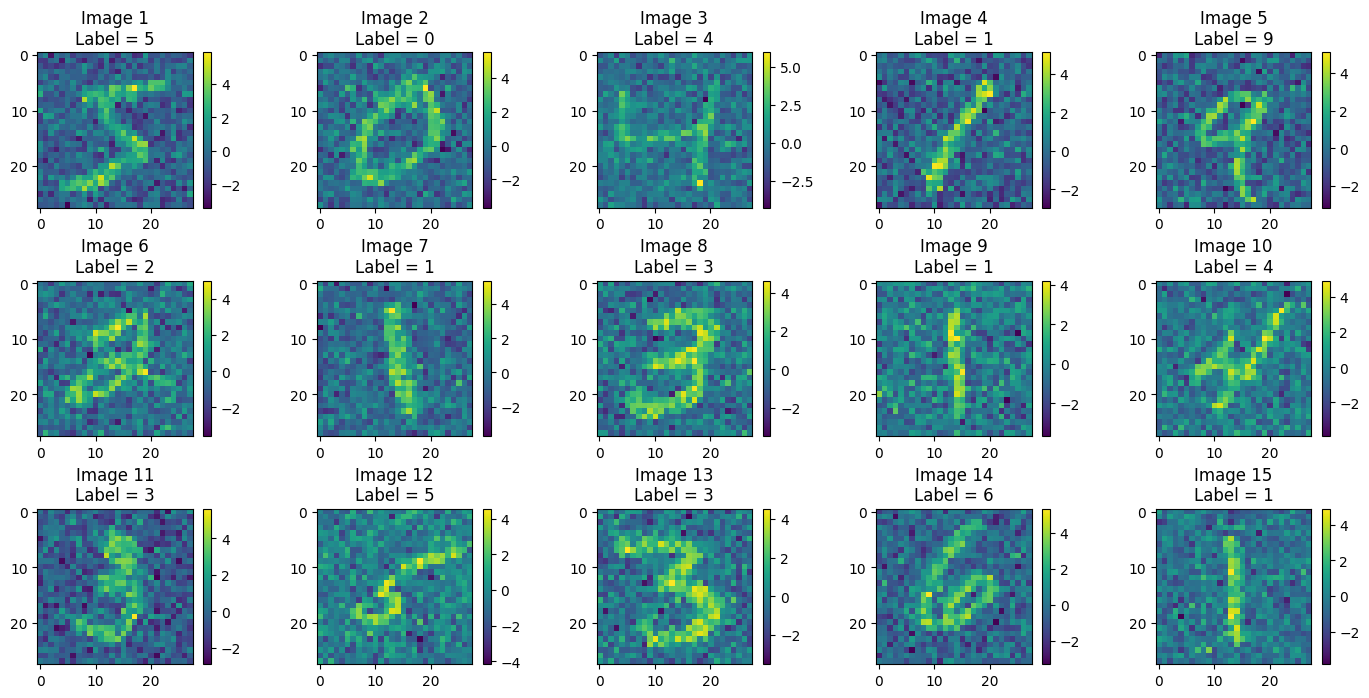

In [ ]:
X_norm = (X - 0.1307)/0.3081
X_noisy = X_norm + 1 * np.random.normal(size=X.shape)
#mu = X_noisy.mean()
#s = X_noisy.std()
#X_noisy = (X_noisy - mu)/s

# Plot some of the noisy MNIST images.
plt.figure(figsize=(14, 7))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.title(f"Image {i + 1}\nLabel = {y[i]}")
    plt.imshow(X_noisy[i, :].reshape(28, 28))
    plt.colorbar()
plt.tight_layout()
plt.show()

### Convert the data for use by PyTorch:
- Convert NumPy arrays to PyTorch tensors
- Convert tensor data into PyTorch DataLoaders

In [ ]:
# Split the data into a training and a test set.
# Reserve the first n_test samples for testing.
n_test = 10000 # <--- ADJUST THE TEST SET SIZE

c = np.random.choice(np.arange(70000),size=940)
train_set = c[:784]
test_set = c[784:]
X_train = X_norm[train_set]#X_norm[n_test:] #
X_noisy_train = X_noisy[train_set]#X_noisy[n_test:] #
y_train = y[train_set]#y[n_test:] #
X_test = X_norm[test_set] #X_norm[:n_test]
X_noisy_test = X_noisy[test_set]#X_noisy[:n_test]
y_test = y[test_set] #y[:n_test]

# Convert data from NumPy arrays to PyTorch tensors.
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
X_noisy_train = torch.from_numpy(X_noisy_train).float()
X_noisy_test = torch.from_numpy(X_noisy_test).float()

print(f"X_train type: {type(X_train)}")
print(f"X_train size: {X_train.size()}")
print()
print(f"y_train type: {type(y_train)}")
print(f"y_train size: {y_train.size()}")
print()

# Use data tensors to build PyTorch Datasets.
train_dataset = TensorDataset(X_noisy_train, y_train)
test_dataset = TensorDataset(X_noisy_test, y_test)

# Use Datasets to build PyTorch DataLoaders.
batch_size = 512 # <--- ADJUST THE BATCH SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Note: DataLoaders are iterable, where each iteration yields a batch of data.
# Grab the first batch from the training loader to see dimensions.
batch_images, batch_labels = next(iter(train_loader))
print(f"batch_images size: {batch_images.size()}")
print(f"batch_labels size: {batch_labels.size()}")

X_train type: <class 'torch.Tensor'>
X_train size: torch.Size([784, 784])

y_train type: <class 'torch.Tensor'>
y_train size: torch.Size([784])

batch_images size: torch.Size([512, 784])
batch_labels size: torch.Size([512])


### Define the activation function

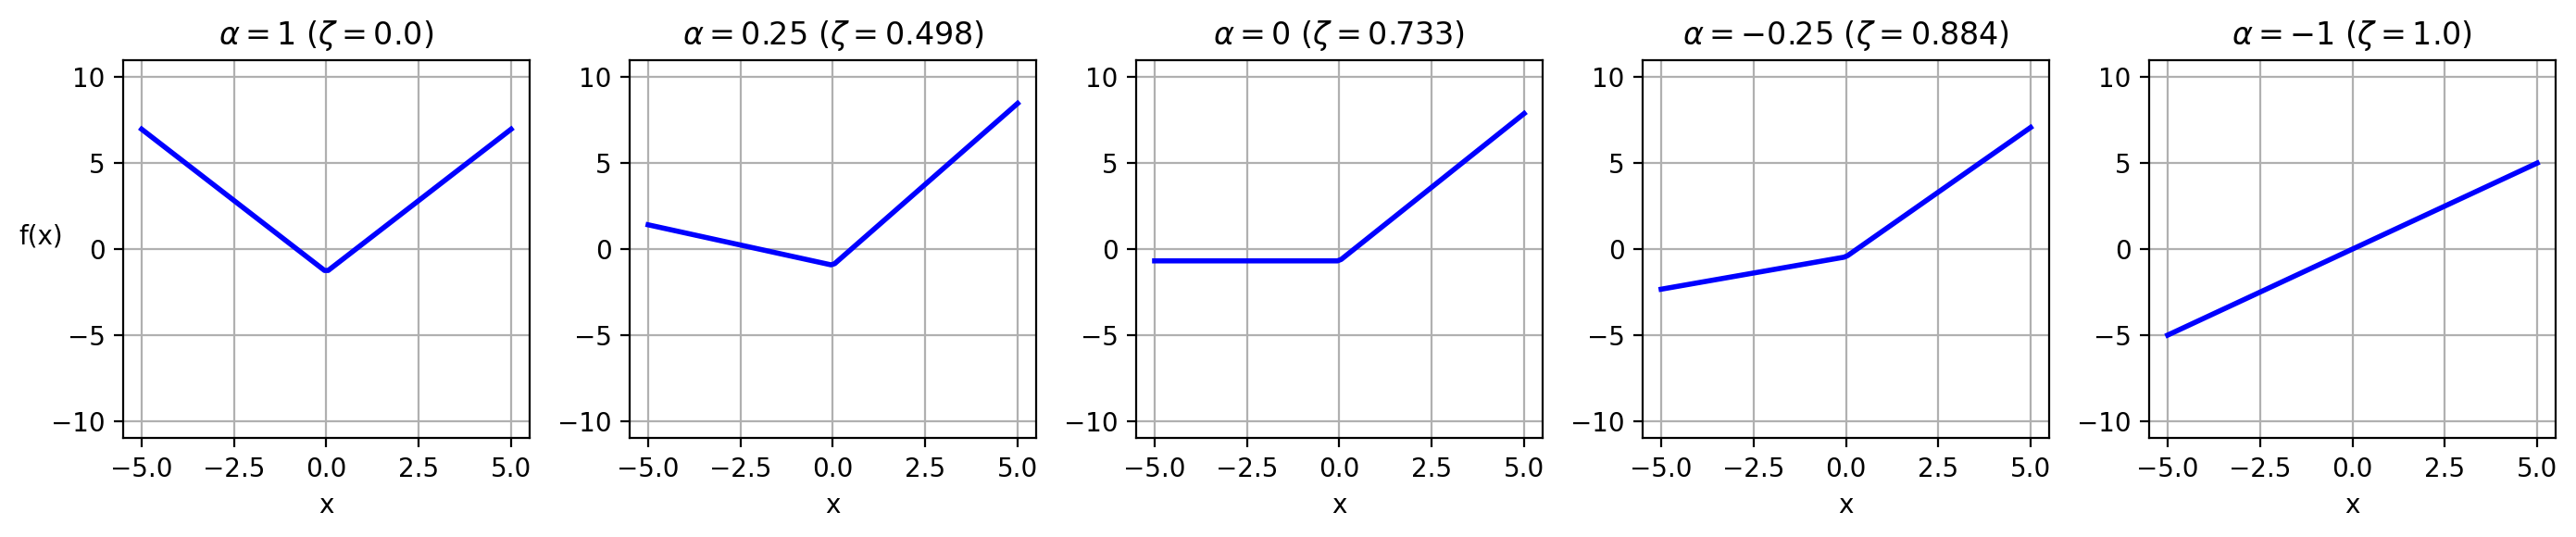

In [ ]:
class ReLU_modified(nn.Module):
    def __init__(self, alpha):
        super(ReLU_modified, self).__init__()
        self._alpha = alpha

    def forward(self, x):
        scale = np.sqrt(0.5 * (1 + self._alpha ** 2) - 0.5 * (1 / np.pi) * (1 + self._alpha) ** 2)
        return (torch.relu(x) + self._alpha * torch.relu(-x) - (1 + self._alpha) / np.sqrt(2 * np.pi)) / scale

def compute_zeta(alpha):
    return (1 - alpha) ** 2 / (2 * (1 + alpha ** 2) - (2 / np.pi) * (1 + alpha) ** 2)

plt.figure(figsize=(14, 3), dpi=200)
x = torch.from_numpy(np.linspace(-5, 5, 100)).float()

for i, alpha in enumerate([1, 0.25, 0, -0.25, -1]):

    plt.subplot(1, 5, i + 1)
    title = "$\\alpha = {}$ $(\zeta = {})$"
    plt.title(title.format(alpha, np.round(compute_zeta(alpha), decimals=3)))
    plt.plot(x.numpy(), ReLU_modified(alpha)(x).numpy(), lw=2, c="b")
    plt.ylim([-11, 11])
    plt.xlabel("x")
    plt.grid()

    if i == 0:
        plt.ylabel("f(x)", rotation=0)

plt.tight_layout()
plt.show()

### Define the neural network architecture

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight,mean=0,std=1/np.sqrt(m.in_features))

### TRAIN THE MODEL!

In [ ]:
def Batchnorm_model():
      n0 = 28 * 28
      n1 = int(n0/6)
      n2 = int(n1/6)
      model = nn.Sequential(
          nn.Linear(n0, n1, bias=False),
          nn.BatchNorm1d(n1),
          nn.Linear(n1, n2, bias=False),
          nn.BatchNorm1d(n2),
          nn.Linear(n2, 10, bias=False)
      )
      model.apply(init_weights)
      return model

def straight_ReLU_model():
      n0 = 28 * 28
      n1 = n0
      n2 = n0
      #n1 = int(n0/6)
      #n2 = int(n1/6)
      model = nn.Sequential(
          nn.Linear(n0, n1, bias=False),
          nn.ReLU(),
          nn.Linear(n1, n2, bias=False),
          nn.ReLU(),
          nn.Linear(n2, 10, bias=False)
      )
      model.apply(init_weights)
      return model

def ReLU_model(alpha):
      n0 = 28 * 28
      n1 = n0
      n2 = n0
      #n1 = int(n0/6)
      #n2 = int(n1/6)
      model = nn.Sequential(
          nn.Linear(n0, n1, bias=False),
          ReLU_modified(alpha),
          nn.Linear(n1, n2, bias=False),
          ReLU_modified(alpha),
          nn.Linear(n2, 10, bias=False)
      )
      model.apply(init_weights)
      return model

def train_and_test_model(model,num_epochs):
    # Define the loss function.
    loss_func = CrossEntropyLoss()

    # Define the neural network optimizer.
    # Pass the optimizer the NN parameters so that it can update them.
    optimizer = Adam(model.parameters(), lr=0.001) # <--- ADJUST THE LEARNING RATE

    # Record loss and accuracy for every epoch.
    all_train_loss = []
    all_train_accuracy = []

    # Train for some number of epochs.
    # Alternatively, train until some accuracy tolerance is met.
    #num_epochs = 10 # <--- ADJUST THE NUMBER OF TRAINING EPOCHS
    for _ in tqdm(range(num_epochs)):

        # Prepare the model for training.
        model.train()

        # Initialize this epoch's loss and accuracy results.
        train_loss = 0.0
        train_accuracy = 0.0

        # Iterate over all images in the train loader to train the model.
        for images, labels in train_loader:

            # Load the data onto the GPU.
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()           # zero the gradient buffers
            pred = model(images)            # pass the images through the model
            loss = loss_func(pred, labels)  # compute cross entropy loss
            train_loss += loss.item()       # record the loss
            loss.backward()                 # compute gradients
            optimizer.step()                # update the model weights

            # Add to the total number of labels predicted correctly.
            pred_classes = torch.argmax(pred, dim=1)
            #print(pred_classes)
            train_accuracy += torch.sum(pred_classes == labels).item()

        # Record the average loss across batches for this epoch.
        all_train_loss.append(train_loss / len(train_loader))

        # Record the accuracy ratio for this epoch.
        all_train_accuracy.append(train_accuracy / (batch_size * len(train_loader)))

    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0

    # Since we aren't training the model, we make this specification.
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            pred = model(images)
            loss = loss_func(pred, labels)
            test_loss += loss.item()

            pred_classes = torch.argmax(pred, dim=1)
            test_accuracy += torch.sum(pred_classes == labels).item()

        test_loss /= len(test_loader)
        test_accuracy /= (batch_size * len(test_loader))

    return all_train_loss, all_train_accuracy, test_loss, test_accuracy

In [ ]:
alpha_results = {"Alphas":[],"Train loss":[],"Train accuracy":[],"Test loss":[],"Test accuracy":[]}
for a in [1,0,-1]:
  model = ReLU_model(a).to(DEVICE)
  train_loss, train_acc, test_loss, test_acc = train_and_test_model(model,10)
  alpha_results["Alphas"].append(a)
  alpha_results["Train loss"].append(train_loss)
  alpha_results["Train accuracy"].append(train_acc)
  alpha_results["Test loss"].append(test_loss)
  alpha_results["Test accuracy"].append(test_acc)

100%|██████████| 10/10 [00:00<00:00, 86.49it/s]


In [ ]:
model = straight_ReLU_model().to(DEVICE)
relu_train_loss, relu_train_acc, relu_test_loss, relu_test_acc = train_and_test_model(model,10)

100%|██████████| 10/10 [00:00<00:00, 94.46it/s]


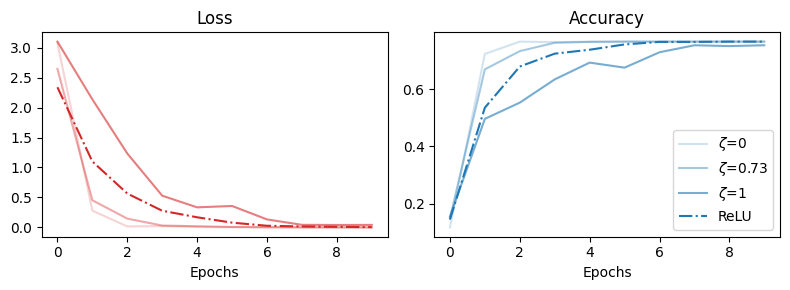

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8, 3))
alphas = [1,0,-1]
zeta = [0,0.73, 1]
for i in range(3):
  train_loss = alpha_results["Train loss"][i]
  train_acc = alpha_results["Train accuracy"][i]
  alpha = alpha_results["Alphas"][i]
  ax[0].plot(train_loss,c="tab:red",alpha=(i+1)/5,label=f"$\zeta$={zeta[i]}",markersize=2)
  ax[0].set_title("Loss")
  ax[0].set_xlabel("Epochs")
  ax[1].plot(train_acc,c="tab:blue",alpha=(i+1)/5,label=f"$\zeta$={zeta[i]}",markersize=2)
  ax[1].set_title("Accuracy")
  ax[1].set_xlabel("Epochs")

ax[0].plot(relu_train_loss,c="tab:red",linestyle ='-.',label="ReLU",markersize=2)
#ax[0].plot(batch_train_loss,c="tab:red",linestyle ='--',label="BatchNorm",markersize=2)
ax[1].plot(relu_train_acc,c="tab:blue",linestyle ='-.',label="ReLU",markersize=2)
#ax[1].plot(batch_train_acc,c="tab:blue",linestyle ='--',label="BatchNorm",markersize=2)
plt.legend()
plt.tight_layout()
plt.show()

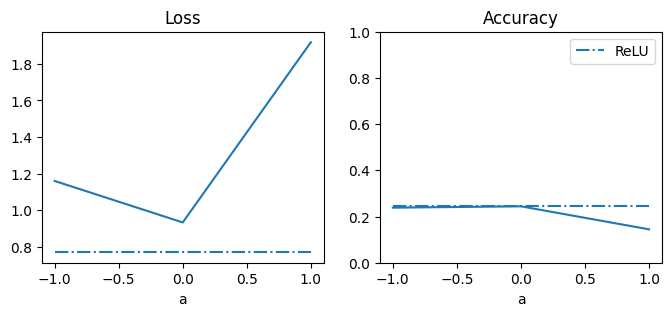

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8, 3))
alphas = alpha_results["Alphas"]
loss = alpha_results["Test loss"]
acc = alpha_results["Test accuracy"]
ax[0].plot(alphas,loss)
ax[0].hlines(relu_test_loss,-1,1,linestyle='-.',label="ReLU")
ax[1].plot(alphas,acc)
ax[1].hlines(relu_test_acc,-1,1,linestyle='-.',label="ReLU")
ax[0].set_title("Loss")
ax[0].set_xlabel("a")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("a")
ax[1].set_ylim([0,1.0])
plt.legend()

In [ ]:
def compute_singular_values(model, X):
    """
    """
    Y = X.to(DEVICE)
    f = model[1]
    s_vals = []

    Y_init = X.cpu().detach().numpy()
    #print((Y_init.T @ Y_init).shape)
    #M = (1/Y_init.shape[0])*(Y_init.T @ Y_init)
    #print(M.shape)
    #s = np.linalg.eigh(M)[0]
    s = np.linalg.svd(Y_init, full_matrices=True, compute_uv=False)
    s_vals.append(s)

    for i, m in enumerate(model):
        if isinstance(m, nn.Linear):

            Y_new = f(m(Y)).cpu().detach().numpy()
            #M = (1/Y_new.shape[0])*(Y_new.T @ Y_new)
            #s = np.linalg.eigh(M)[0]
            s = np.linalg.svd(Y_new, full_matrices=True, compute_uv=False)
            s_vals.append(s)
            Y = torch.from_numpy(Y_new).float().to(DEVICE)

    return s_vals

100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


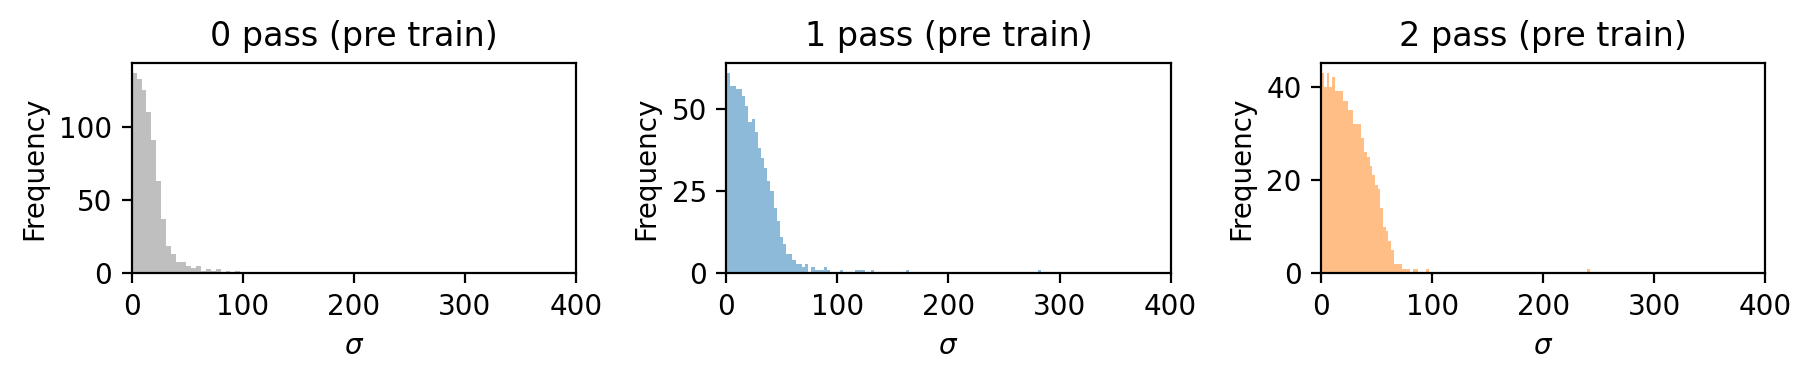

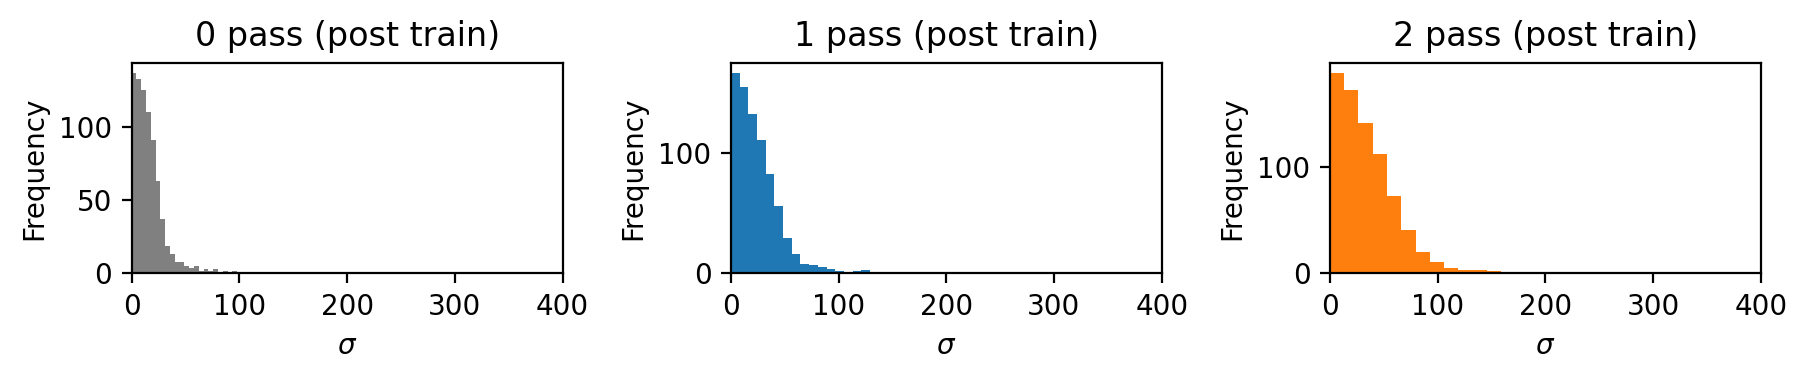

In [ ]:
model = ReLU_model(1).to(DEVICE)
#X_noisy = torch.from_numpy(X_noisy).float()
s_vals_pretrain = compute_singular_values(model, X_noisy_train)
train_loss, train_acc, test_loss, test_acc = train_and_test_model(model,10)
s_vals_posttrain = compute_singular_values(model, X_noisy_train)

colors = ["grey", "tab:blue", "tab:orange", "tab:green"]
plt.figure(figsize=(12, 2), dpi=200)
n = len(s_vals_pretrain)
for i in range(n-1):
    plt.subplot(1, n, i + 1)
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    plt.hist(pre, bins=100, color=colors[i], alpha=0.5, label=f"{i} pass (pre-train)")

    plt.xlabel("$\sigma$")
    plt.ylabel("Frequency")
    plt.title(f"{i} pass (pre train)")
    plt.xlim([0,400])
plt.tight_layout()

plt.figure(figsize=(12, 2), dpi=200)
n = len(s_vals_pretrain)
for i in range(n-1):
    plt.subplot(1, n, i + 1)
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    plt.hist(post, bins=100, color=colors[i], alpha=1.0, label=f"{i} pass (post-train)")

    plt.xlabel("$\sigma$")
    plt.ylabel("Frequency")
    plt.title(f"{i} pass (post train)")
    plt.xlim([0,400])
plt.tight_layout()
#plt.legend()
#plt.semilogx()
#plt.xlim([0,10])
plt.show()

100%|██████████| 10/10 [00:01<00:00,  8.79it/s]


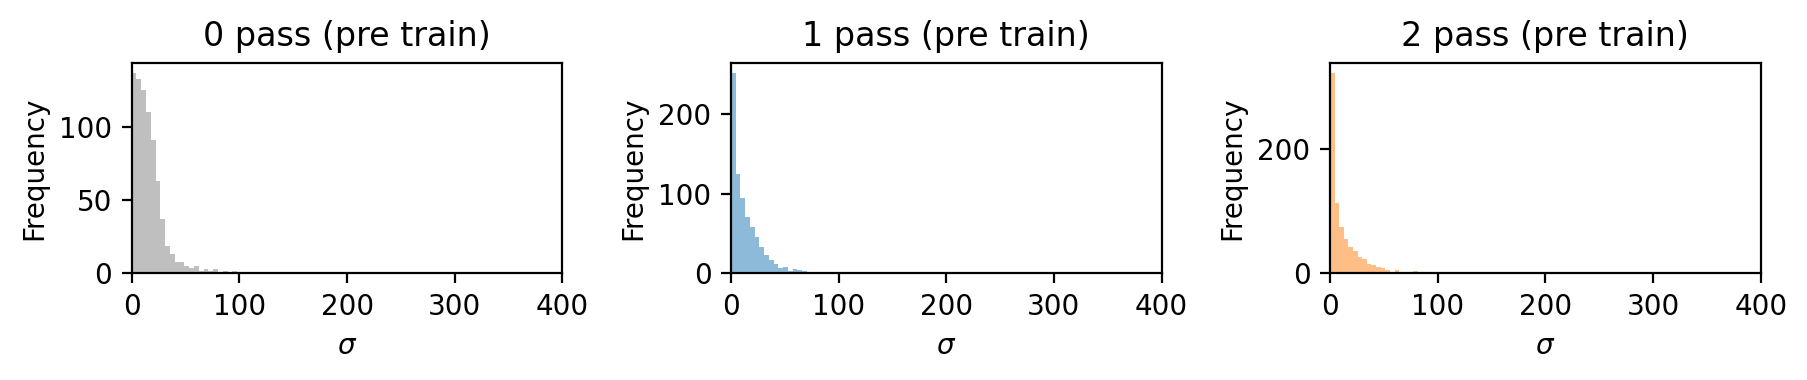

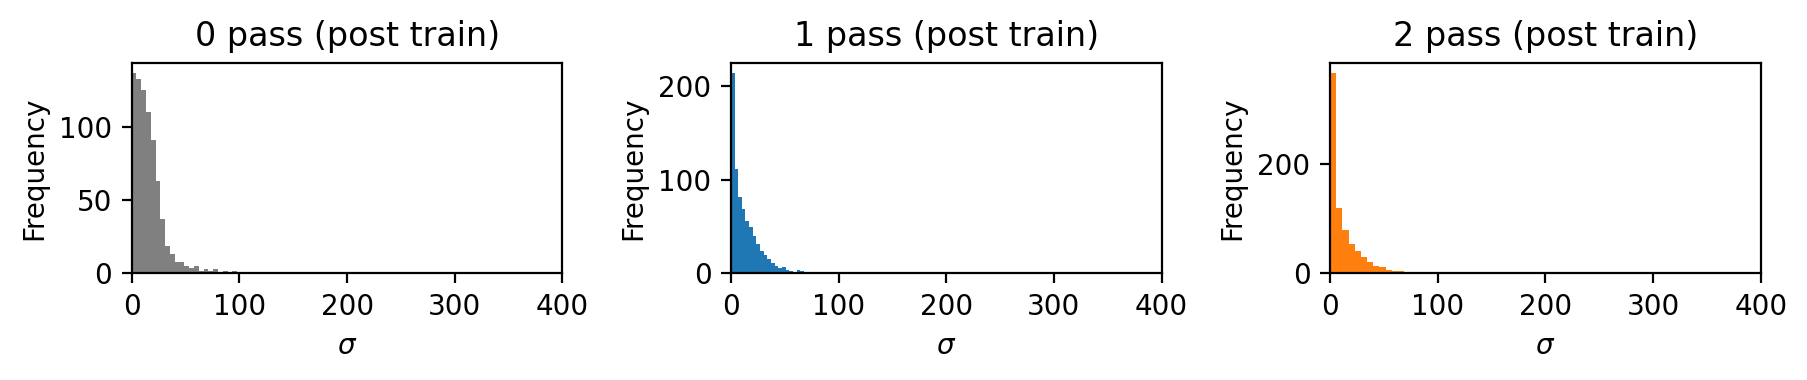

In [ ]:
model = ReLU_model(-1).to(DEVICE)
s_vals_pretrain = compute_singular_values(model, X_noisy_train)
train_loss, train_acc, test_loss, test_acc = train_and_test_model(model,10)
s_vals_posttrain = compute_singular_values(model, X_noisy_train)

colors = ["grey", "tab:blue", "tab:orange", "tab:green"]
plt.figure(figsize=(12, 2), dpi=200)
#fig,ax = plt.subplots(1,2)
n = len(s_vals_pretrain)
for i in range(n-1):
    plt.subplot(1, n, i + 1)
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    plt.hist(pre, bins=100, color=colors[i], alpha=0.5, label=f"{n-i-1} pass (pre-train)")

    plt.xlabel("$\sigma$")
    plt.ylabel("Frequency")
    plt.title(f"{i} pass (pre train)")
    plt.xlim([0,400])
plt.tight_layout()

plt.figure(figsize=(12, 2), dpi=200)
n = len(s_vals_pretrain)
for i in range(n-1):
    plt.subplot(1, n, i + 1)
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    plt.hist(post, bins=100, color=colors[i], alpha=1.0, label=f"{i} pass (post-train)")

    plt.xlabel("$\sigma$")
    plt.ylabel("Frequency")
    plt.title(f"{i} pass (post train)")
    plt.xlim([0,400])

plt.tight_layout()
plt.show()


100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


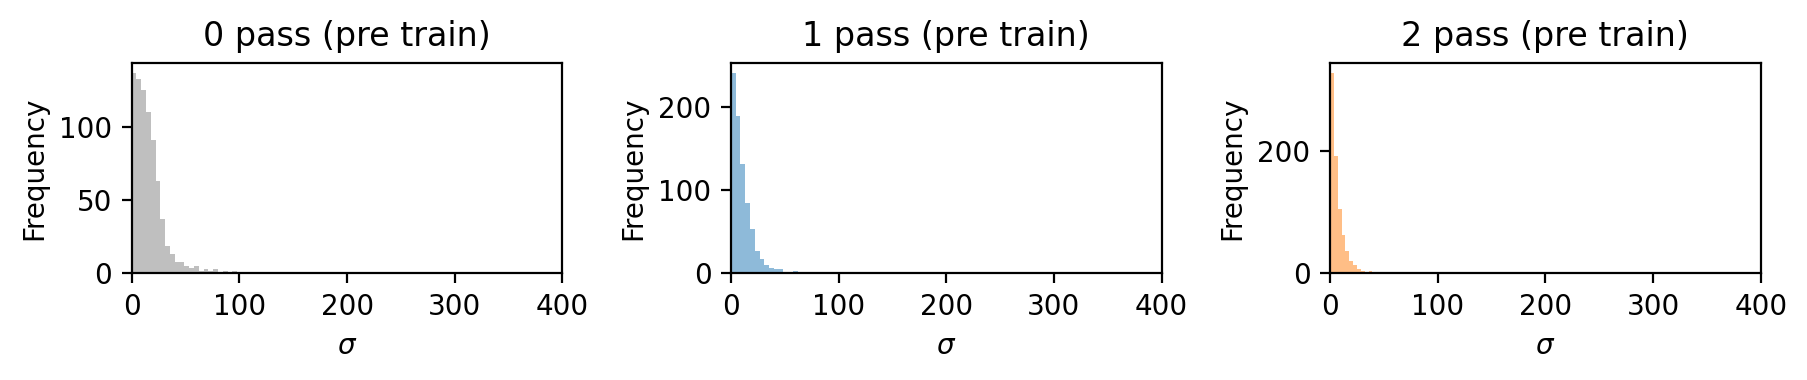

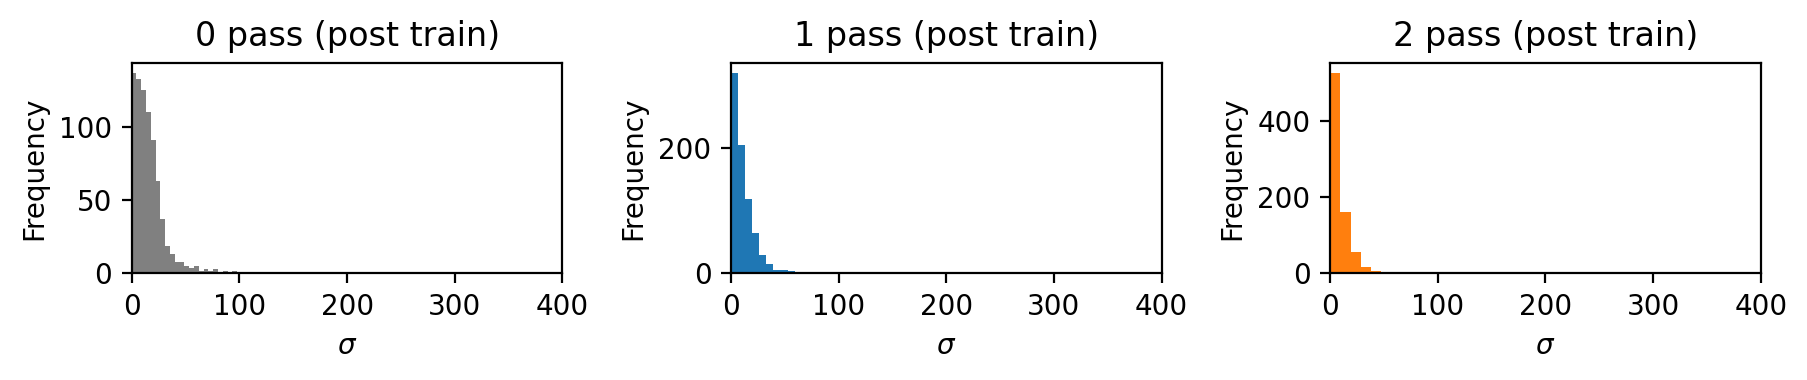

In [ ]:
model = straight_ReLU_model().to(DEVICE)
s_vals_pretrain = compute_singular_values(model, X_noisy_train)
train_loss, train_acc, test_loss, test_acc = train_and_test_model(model,10)
s_vals_posttrain = compute_singular_values(model, X_noisy_train)

colors = ["grey", "tab:blue", "tab:orange", "tab:green"]
plt.figure(figsize=(12, 2), dpi=200)
#fig,ax = plt.subplots(1,2)
n = len(s_vals_pretrain)
for i in range(n-1):
    plt.subplot(1, n, i + 1)
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    plt.hist(pre, bins=100, color=colors[i], alpha=0.5, label=f"{n-i-1} pass (pre-train)")

    plt.xlabel("$\sigma$")
    plt.ylabel("Frequency")
    plt.title(f"{i} pass (pre train)")
    plt.xlim([0,400])
plt.tight_layout()

plt.figure(figsize=(12, 2), dpi=200)
n = len(s_vals_pretrain)
for i in range(n-1):
    plt.subplot(1, n, i + 1)
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    plt.hist(post, bins=100, color=colors[i], alpha=1.0, label=f"{i} pass (post-train)")

    plt.xlabel("$\sigma$")
    plt.ylabel("Frequency")
    plt.title(f"{i} pass (post train)")
    plt.xlim([0,400])
plt.tight_layout()
plt.show()

100%|██████████| 10/10 [00:00<00:00, 10.01it/s]


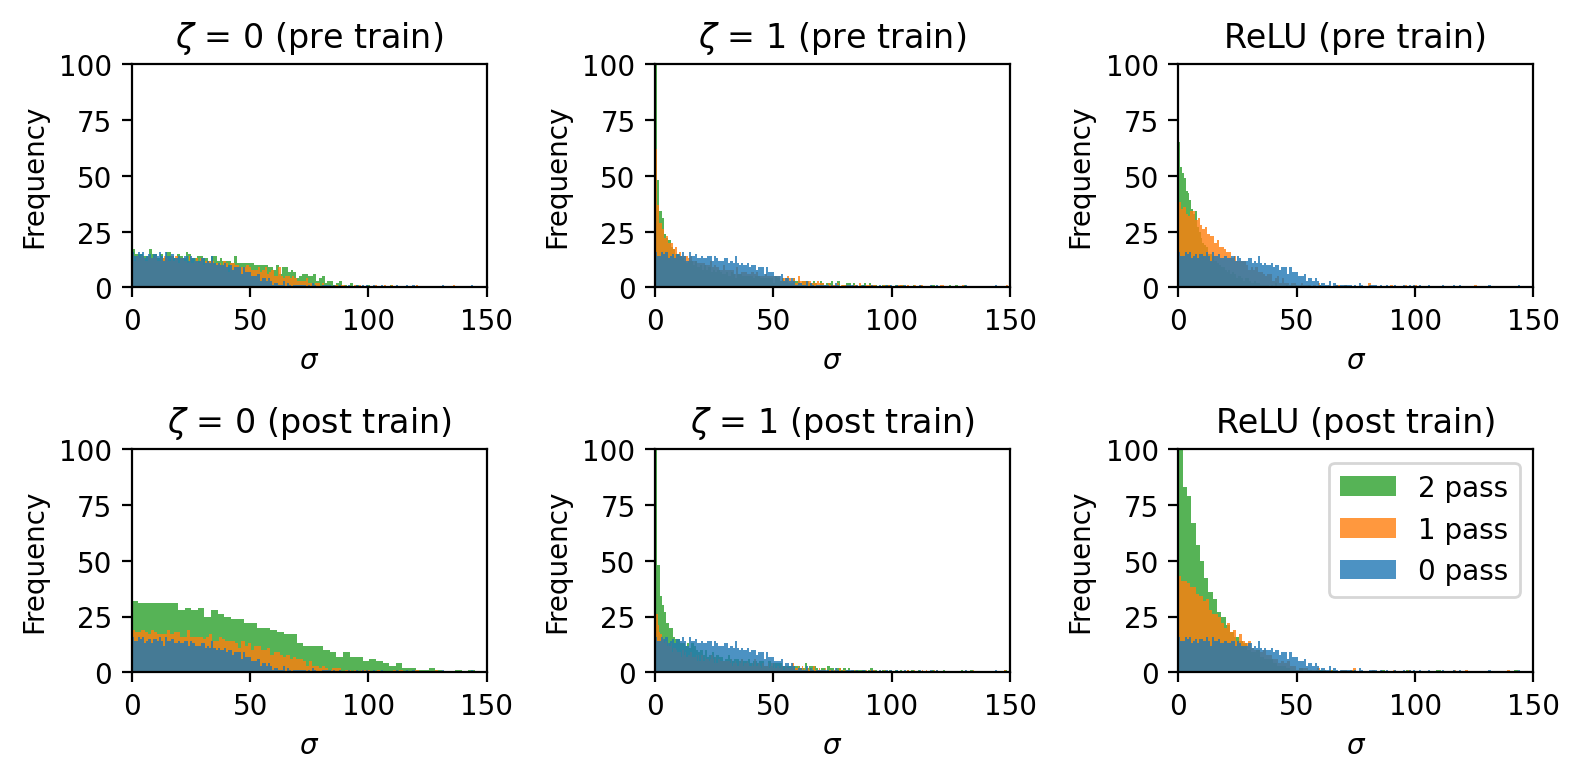

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(8, 4), dpi=200)

colors = ["tab:blue", "tab:orange", "tab:green","tab:grey"]

model = ReLU_model(1).to(DEVICE)
s_vals_pretrain = compute_singular_values(model, X_noisy_train)
train_loss, train_acc, test_loss, test_acc = train_and_test_model(model,10)
s_vals_posttrain = compute_singular_values(model, X_noisy_train)

n = len(s_vals_pretrain)
for i in range(n-2,-1,-1):
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    ax[0,0].hist(pre, bins=500, color=colors[i], alpha=0.8, label=f"{i} pass")
    ax[1,0].hist(post, bins=500, color=colors[i], alpha=0.8)

    ax[0,0].set_xlabel("$\sigma$")
    ax[1,0].set_xlabel("$\sigma$")
    ax[0,0].set_ylabel("Frequency")
    ax[1,0].set_ylabel("Frequency")
    ax[0,0].set_title(f"$\zeta$ = {0} (pre train)")
    ax[1,0].set_title(f"$\zeta$ = {0} (post train)")
    ax[0,0].set_xlim([0,150])
    ax[1,0].set_xlim([0,150])
    ax[0,0].set_ylim([0,100])
    ax[1,0].set_ylim([0,100])

model = ReLU_model(-1).to(DEVICE)
s_vals_pretrain = compute_singular_values(model, X_noisy_train)
train_loss, train_acc, test_loss, test_acc = train_and_test_model(model,10)
s_vals_posttrain = compute_singular_values(model, X_noisy_train)

n = len(s_vals_pretrain)
for i in range(n-2,-1,-1):
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    ax[0,1].hist(pre, bins=500, color=colors[i], alpha=0.8, label=f"{i} pass")
    ax[1,1].hist(post, bins=500, color=colors[i], alpha=0.8)

    ax[0,1].set_xlabel("$\sigma$")
    ax[1,1].set_xlabel("$\sigma$")
    ax[0,1].set_ylabel("Frequency")
    ax[1,1].set_ylabel("Frequency")
    ax[0,1].set_title(f"$\zeta$ = {1} (pre train)")
    ax[1,1].set_title(f"$\zeta$ = {1} (post train)")
    ax[0,1].set_xlim([0,150])
    ax[1,1].set_xlim([0,150])
    ax[0,1].set_ylim([0,100])
    ax[1,1].set_ylim([0,100])

model = straight_ReLU_model().to(DEVICE)
s_vals_pretrain = compute_singular_values(model, X_noisy_train)
train_loss, train_acc, test_loss, test_acc = train_and_test_model(model,10)
s_vals_posttrain = compute_singular_values(model, X_noisy_train)

n = len(s_vals_pretrain)
for i in range(n-2,-1,-1):
    pre = np.array(s_vals_pretrain[i])
    post = np.array(s_vals_posttrain[i])
    ax[0,2].hist(pre, bins=500, color=colors[i], alpha=0.8)
    ax[1,2].hist(post, bins=500, color=colors[i], alpha=0.8, label=f"{i} pass")
    ax[0,2].set_xlabel("$\sigma$")
    ax[1,2].set_xlabel("$\sigma$")
    ax[0,2].set_ylabel("Frequency")
    ax[1,2].set_ylabel("Frequency")
    ax[0,2].set_title(f"ReLU (pre train)")
    ax[1,2].set_title(f"ReLU (post train)")
    ax[0,2].set_xlim([0,150])
    ax[1,2].set_xlim([0,150])
    ax[0,2].set_ylim([0,100])
    ax[1,2].set_ylim([0,100])
    ax[1,2].legend()

plt.tight_layout()
plt.show()